---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, **and Null if the violator was found not responsible.** Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

**Note: All tickets where the violators were found not responsible are not considered during evaluation.** They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    train.csv - the training set (all tickets issued 2004-2011)
    test.csv - the test set (all tickets issued 2012-2016)
    addresses.csv & latlons.csv - mapping from ticket id to addresses (violation address), and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the **Area Under the ROC Curve (AUC).** 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
# pd.reset_option("display.max_columns")   # reset

In [2]:
train = pd.read_csv("train.csv", dtype={"agency_name": "category",
                                     "violation_code": "category",
                                     "zip_code":"category"})    # dtype={'user_id': int}
test = pd.read_csv("test.csv", dtype={"agency_name": "category",
                                     "violation_code": "category",
                                     "zip_code":"category"})

train.shape,test.shape

/Users/chujiechen/opt/anaconda3/envs/ai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


((250306, 34), (61001, 27))

In [3]:
# first look
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   ticket_id                   250306 non-null  int64   
 1   agency_name                 250306 non-null  category
 2   inspector_name              250306 non-null  object  
 3   violator_name               250272 non-null  object  
 4   violation_street_number     250306 non-null  float64 
 5   violation_street_name       250306 non-null  object  
 6   violation_zip_code          0 non-null       float64 
 7   mailing_address_str_number  246704 non-null  float64 
 8   mailing_address_str_name    250302 non-null  object  
 9   city                        250306 non-null  object  
 10  state                       250213 non-null  object  
 11  zip_code                    250305 non-null  category
 12  non_us_str_code             3 non-null       object  
 13 

In [4]:
train.describe()

ticket_id  violation_street_number  violation_zip_code  \
count  250306.000000             2.503060e+05                 0.0   
mean   152665.543099             1.064986e+04                 NaN   
std     77189.882881             3.188733e+04                 NaN   
min     18645.000000             0.000000e+00                 NaN   
25%     86549.250000             4.739000e+03                 NaN   
50%    152597.500000             1.024400e+04                 NaN   
75%    219888.750000             1.576000e+04                 NaN   
max    366178.000000             1.415411e+07                 NaN   

       mailing_address_str_number    fine_amount      admin_fee  \
count                2.467040e+05  250305.000000  250306.000000   
mean                 9.149788e+03     374.423435      12.774764   
std                  3.602034e+04     707.195807       9.607344   
min                  1.000000e+00       0.000000       0.000000   
25%                  5.440000e+02     200.000000       0.000000   
50%                  2.456000e+03     250.000000      20.000000   
75%                  1.292725e+04     250.000000      20.000000   
max                  5.111345e+06   10000.000000      20.000000   

           state_fee       late_fee  discount_amount  clean_up_cost  \
count  250306.000000  250306.000000    250306.000000       250306.0   
mean        6.387382      21.494506         0.125167            0.0   
std         4.803672      56.464263         3.430178            0.0   
min         0.000000       0.000000         0.000000            0.0   
25%         0.000000       0.000000         0.000000            0.0   
50%        10.000000      10.000000         0.000000            0.0   
75%        10.000000      25.000000         0.000000            0.0   
max        10.000000    1000.000000       350.000000            0.0   

       judgment_amount  payment_amount    balance_due     compliance  
count    250306.000000   250306.000000  250306.000000  159880.000000  
mean        268.685356       48.898986     222.449058       0.072536  
std         626.915212      222.422425     606.394010       0.259374  
min           0.000000        0.000000   -7750.000000       0.000000  
25%           0.000000        0.000000       0.000000       0.000000  
50%         140.000000        0.000000      25.000000       0.000000  
75%         305.000000        0.000000     305.000000       0.000000  
max       11030.000000    11075.000000   11030.000000       1.000000

In [5]:
train.isnull().sum()

ticket_id                          0
agency_name                        0
inspector_name                     0
violator_name                     34
violation_street_number            0
violation_street_name              0
violation_zip_code            250306
mailing_address_str_number      3602
mailing_address_str_name           4
city                               0
state                             93
zip_code                           1
non_us_str_code               250303
country                            0
ticket_issued_date                 0
hearing_date                   12491
violation_code                     0
violation_description              0
disposition                        0
fine_amount                        1
admin_fee                          0
state_fee                          0
late_fee                           0
discount_amount                    0
clean_up_cost                      0
judgment_amount                    0
payment_amount                     0
b

In [6]:
## formatting
df = train.copy()
# cannot include features not avaliable at evaluation stage
features = ['ticket_id',
            'agency_name',
#             'zip_code', 
#             'state',
            'country', # no non-US country in test set
            'ticket_issued_date', 
            'hearing_date',
            'violation_code', 
            'fine_amount', 
            'admin_fee',
            'state_fee', 
            'late_fee', 
            'discount_amount', 
            'clean_up_cost',
            'judgment_amount', 
            'compliance']
df = df[features]
df = df.dropna(subset=['compliance'])
# df = df[~df.isnull().any(axis=1)]
df = df.astype({'compliance': 'int32'})
df.ticket_issued_date = pd.to_datetime(df.ticket_issued_date, format='%Y-%m-%d', errors='ignore')
df.hearing_date = pd.to_datetime(df.hearing_date, format='%Y-%m-%d', errors='ignore')

In [7]:
addresses = pd.read_csv("addresses.csv")
latlons = pd.read_csv("latlons.csv")

In [8]:
df = df.join(addresses.set_index('ticket_id'), on='ticket_id')
df = df.join(latlons.set_index('address'), on='address')
df = df.drop(['ticket_id', 'address'], axis=1)

In [9]:
## clean up
df.isnull().sum()

agency_name             0
country                 0
ticket_issued_date      0
hearing_date          227
violation_code          0
fine_amount             0
admin_fee               0
state_fee               0
late_fee                0
discount_amount         0
clean_up_cost           0
judgment_amount         0
compliance              0
lat                     2
lon                     2
dtype: int64

In [10]:
df = df.fillna(df.mode().iloc[0])

In [11]:
df.isnull().sum()

agency_name           0
country               0
ticket_issued_date    0
hearing_date          0
violation_code        0
fine_amount           0
admin_fee             0
state_fee             0
late_fee              0
discount_amount       0
clean_up_cost         0
judgment_amount       0
compliance            0
lat                   0
lon                   0
dtype: int64

In [12]:
## datetime
from datetime import timedelta
df['hearing_date'] = df['hearing_date'].fillna(df['ticket_issued_date']+timedelta(np.mean((df.hearing_date - df.ticket_issued_date).dt.days)))

def getYMDH(df, column, prefix, drop_original=True):
#     df[prefix + 'year'] = df[column].dt.year
    df[prefix + 'month'] = df[column].dt.month
#     df[prefix + 'day'] = df[column].dt.day
#     df[prefix + 'hour'] = df[column].dt.hour
    df[prefix + 'dayofweek'] = df[column].dt.dayofweek
    if drop_original:
        df = df.drop(column, axis=1)
    return df


In [13]:
df['day_diff'] = (df.hearing_date - df.ticket_issued_date).dt.days
df = getYMDH(df, "ticket_issued_date", "ticket_", drop_original=True)
df = getYMDH(df, "hearing_date", "hearing_", drop_original=True)

In [14]:
# ## location discretization
# from sklearn.preprocessing import KBinsDiscretizer
# enc = KBinsDiscretizer(n_bins=10, encode='onehot')
# df_loc = pd.DataFrame(enc.fit_transform(df[['lat', 'lon']]).toarray(), 
#                       columns=['lat'+str(x) for x in range(10)] + ['lon'+str(x) for x in range(10)])
#### Coursera does not have the lateset sklearn

In [15]:
# df = df.reset_index(drop=True)
# df = pd.concat([df, df_loc.reindex(df.index)], axis=1)
# df = df.drop(['lat', 'lon'], axis=1)

In [16]:
## zip_code
df = df[df.country == 'USA']  # all test entries are in USA
# def decode_zip_code(df, col, drop_original=True):
#     df[col+"_area"] = np.array([x[:1] for x in df[col]])
#     df[col+"_city"] = np.array([x[1:3] for x in df[col]])
#     if drop_original:
#         return df.drop(col, axis=1)
#     return df

In [17]:
# df = decode_zip_code(df, 'zip_code')
df = df.drop("country", axis=1)

In [18]:
## categorical features
#     print(len(set(df.zip_code_area)),len(set(df.zip_code_city)),len(set(df.agency_name)),len(set(df.violation_code)))
# using pandas.get_dummies
df = pd.get_dummies(df, columns=[
#         "zip_code_area", "zip_code_city", 
    "agency_name", "violation_code"], prefix=[
#         "area_", "city_", 
    "agency_", "vio_"])

In [19]:
df.shape

(159869, 255)

# baseline model with Dummy
## No preprocessing

In [20]:
from sklearn.model_selection import train_test_split
X = df.drop('compliance', axis=1)
y = df.compliance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
# accuracy, precision, recall, F1 score
accuracy = dummy_clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
accuracy, precision, recall, f1_score

(0.8630904723779024,
 0.07175358767938397,
 0.0706896551724138,
 0.07121764808059754)

# baseline model with logistic regression
## No preprocessing

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
clf = LogisticRegression(random_state=0, max_iter=100).fit(X_train, y_train)
y_pred = clf.predict(X_test)
# accuracy, precision, recall, F1 score
accuracy = clf.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
accuracy, precision, recall, f1_score

/Users/chujiechen/opt/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9336469175340272,
 0.8054187192118226,
 0.11275862068965517,
 0.19782214156079853)

<ipython-input-23-e10e7e54f505>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


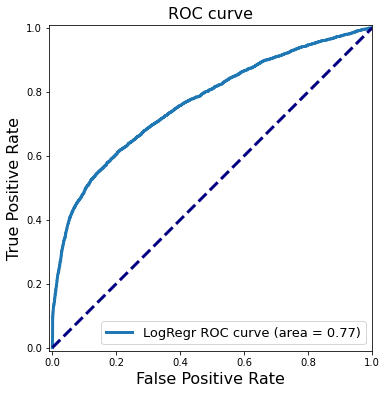

In [23]:
from sklearn.metrics import roc_curve, auc
# y_score = clf.decision_function(X_test)
y_score = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [24]:
roc_auc

0.7663062991408149

# baseline model with Logistic Regression
## With preprocessing

In [25]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
clf = LogisticRegression(C=1.0, random_state=None, max_iter=100).fit(X_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
# accuracy, precision, recall, F1 score
accuracy = clf.score(X_test_scaled, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
accuracy, precision, recall, f1_score

/Users/chujiechen/opt/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.928142514011209,
 0.7333333333333333,
 0.015172413793103448,
 0.029729729729729728)

In [27]:
print('Accuracy of LR classifier on training set: {:.2f}'
     .format(clf.score(X_scaled, y_train)))
print('Accuracy of LR classifier on test set: {:.2f}'
     .format(clf.score(X_test_scaled, y_test)))

Accuracy of LR classifier on training set: 0.93
Accuracy of LR classifier on test set: 0.93


<ipython-input-28-75582bcf8f67>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


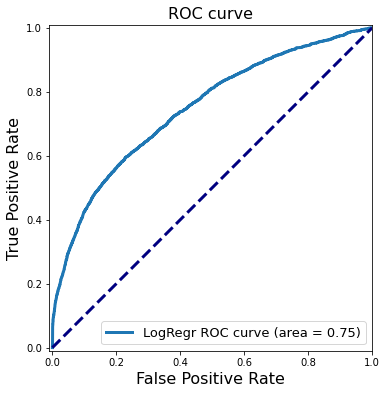

In [28]:
from sklearn.metrics import roc_curve, auc
# y_score = clf.decision_function(X_test_scaled)
y_score = clf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [29]:
roc_auc

0.7466629968036377

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import roc_auc_score

# grid_values = {'C': [0.001, 0.1, 1, 10, 100]}

# # alternative metric to optimize over grid parameters: AUC
# grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc', cv=3)
# grid_clf_auc.fit(X_scaled, y_train)
# y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test_scaled) 

# print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
# print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
# print('Grid best score (AUC): ', grid_clf_auc.best_score_)

# Tree-based model with GradientBoostingClassifier

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

clf = GradientBoostingClassifier().fit(X_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
# accuracy, precision, recall, F1 score
accuracy = clf.score(X_test_scaled, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1_score = f1_score(y_test, y_pred)
accuracy, precision, recall, f1_score

(0.935123098478783,
 0.9205479452054794,
 0.11586206896551725,
 0.20581929555895867)

<ipython-input-31-75582bcf8f67>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


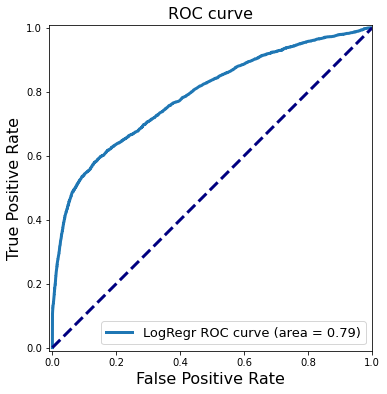

In [31]:
from sklearn.metrics import roc_curve, auc
# y_score = clf.decision_function(X_test_scaled)
y_score = clf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# alternative metric to optimize over grid parameters: AUC
grid_values = {'learning_rate': [0.01, 0.1, 1.0], 'max_depth': [2,3,4]}
grid_clf_auc = GridSearchCV(clf, param_grid = grid_values, scoring = 'roc_auc', cv=3, verbose=3)
grid_clf_auc.fit(X_train, y_train)
y_decision_fn_scores_auc = grid_clf_auc.decision_function(X_test) 

print('Test set AUC: ', roc_auc_score(y_test, y_decision_fn_scores_auc))
print('Grid best parameter (max. AUC): ', grid_clf_auc.best_params_)
print('Grid best score (AUC): ', grid_clf_auc.best_score_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] learning_rate=0.01, max_depth=2 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... learning_rate=0.01, max_depth=2, score=0.769, total=  26.1s
[CV] learning_rate=0.01, max_depth=2 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.1s remaining:    0.0s


[CV] ..... learning_rate=0.01, max_depth=2, score=0.776, total=  25.3s
[CV] learning_rate=0.01, max_depth=2 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   51.4s remaining:    0.0s


[CV] ..... learning_rate=0.01, max_depth=2, score=0.764, total=  20.9s
[CV] learning_rate=0.01, max_depth=3 .................................
[CV] ..... learning_rate=0.01, max_depth=3, score=0.782, total=  29.7s
[CV] learning_rate=0.01, max_depth=3 .................................
[CV] ..... learning_rate=0.01, max_depth=3, score=0.786, total=  29.3s
[CV] learning_rate=0.01, max_depth=3 .................................
[CV] ..... learning_rate=0.01, max_depth=3, score=0.781, total=  29.8s
[CV] learning_rate=0.01, max_depth=4 .................................
[CV] ..... learning_rate=0.01, max_depth=4, score=0.787, total=  38.0s
[CV] learning_rate=0.01, max_depth=4 .................................
[CV] ..... learning_rate=0.01, max_depth=4, score=0.790, total=  37.2s
[CV] learning_rate=0.01, max_depth=4 .................................
[CV] ..... learning_rate=0.01, max_depth=4, score=0.787, total=  36.7s
[CV] learning_rate=0.1, max_depth=2 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 13.9min finished


Test set AUC:  0.7925324241003486
Grid best parameter (max. AUC):  {'learning_rate': 0.1, 'max_depth': 4}
Grid best score (AUC):  0.798869234447085


# Test submission

In [1]:
import pandas as pd
import numpy as np
pd.reset_option("display.max_columns")   # reset
train = pd.read_csv("train.csv", dtype={"agency_name": "category",
                                     "violation_code": "category",
                                     "zip_code":"category"})    # dtype={'user_id': int}
test = pd.read_csv("test.csv", dtype={"agency_name": "category",
                                     "violation_code": "category",
                                     "zip_code":"category"})
train.shape, test.shape

/Users/chujiechen/opt/anaconda3/envs/ai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


((250306, 34), (61001, 27))

In [2]:
train = train.dropna(subset=['compliance'])
train = train[train.country == 'USA']
train.shape, test.shape

((159869, 34), (61001, 27))

In [3]:
features = ['ticket_id',
            'agency_name',
            'zip_code', 
#             'state',
            'country', # no non-US country in test set
            'ticket_issued_date', 
            'hearing_date',
            'violation_code', 
            'fine_amount', 
            'admin_fee',
            'state_fee', 
            'late_fee', 
            'discount_amount', 
            'clean_up_cost',
            'judgment_amount']
train_copy, test = train[features], test[features]
df = pd.concat([train_copy, test], axis = 0)
df.shape, df[-61001:].shape

((220870, 14), (61001, 14))

In [4]:
df[-61001:].head()

ticket_id                 agency_name zip_code country  \
0     284932  Department of Public Works    48213     USA   
1     285362  Department of Public Works    48219     USA   
2     285361  Department of Public Works    48219     USA   
3     285338  Department of Public Works    48183     USA   
4     285346  Department of Public Works    48154     USA   

    ticket_issued_date         hearing_date violation_code  fine_amount  \
0  2012-01-04 14:00:00  2012-01-19 09:00:00        22-2-61        200.0   
1  2012-01-05 09:50:00  2012-02-06 09:00:00     22-2-88(b)       1000.0   
2  2012-01-05 09:50:00  2012-02-06 09:00:00        22-2-43        100.0   
3  2012-01-05 10:25:00  2012-02-07 09:00:00     22-2-88(b)        200.0   
4  2012-01-05 10:20:00  2012-02-14 09:00:00        22-2-45        100.0   

   admin_fee  state_fee  late_fee  discount_amount  clean_up_cost  \
0       20.0       10.0      20.0              0.0            0.0   
1       20.0       10.0     100.0              0.0            0.0   
2       20.0       10.0      10.0              0.0            0.0   
3       20.0       10.0      20.0              0.0            0.0   
4       20.0       10.0      10.0              0.0            0.0   

   judgment_amount  
0            250.0  
1           1130.0  
2            140.0  
3            250.0  
4            140.0

In [5]:
df.ticket_issued_date = pd.to_datetime(df.ticket_issued_date, format='%Y-%m-%d', errors='ignore')
df.hearing_date = pd.to_datetime(df.hearing_date, format='%Y-%m-%d', errors='ignore')
addresses = pd.read_csv("addresses.csv")
latlons = pd.read_csv("latlons.csv")
df = df.join(addresses.set_index('ticket_id'), on='ticket_id')
df = df.join(latlons.set_index('address'), on='address')
df = df.drop(['ticket_id', 'address'], axis=1)
df = df.fillna(df.mode().iloc[0])

In [6]:
## datetime
from datetime import timedelta
df['hearing_date'] = df['hearing_date'].fillna(df['ticket_issued_date']+timedelta(np.mean((df.hearing_date - df.ticket_issued_date).dt.days)))

def getYMDH(df, column, prefix, drop_original=True):
    df[prefix + 'year'] = df[column].dt.year
    df[prefix + 'month'] = df[column].dt.month
    df[prefix + 'day'] = df[column].dt.day
    df[prefix + 'hour'] = df[column].dt.hour
    df[prefix + 'dayofweek'] = df[column].dt.dayofweek
    if drop_original:
        df = df.drop(column, axis=1)
    return df

df['day_diff'] = (df.hearing_date - df.ticket_issued_date).dt.days
df = getYMDH(df, "ticket_issued_date", "ticket_", drop_original=True)
df = getYMDH(df, "hearing_date", "hearing_", drop_original=True)


In [7]:
## location discretization
from sklearn.preprocessing import KBinsDiscretizer
enc = KBinsDiscretizer(n_bins=10, encode='onehot')
df_loc = pd.DataFrame(enc.fit_transform(df[['lat', 'lon']]).toarray(), 
                      columns=['lat'+str(x) for x in range(10)] + ['lon'+str(x) for x in range(10)])
df = df.reset_index(drop=True)
df = pd.concat([df, df_loc.reindex(df.index)], axis=1)
df = df.drop(['lat', 'lon'], axis=1)



In [8]:
## zip_code
df = df[df.country == 'USA']  # all test entries are in USA
def decode_zip_code(df, col, drop_original=True):
    df[col+"_area"] = np.array([x[:1] for x in df[col]])
    df[col+"_city"] = np.array([x[1:3] for x in df[col]])
    if drop_original:
        return df.drop(col, axis=1)
    return df

df = decode_zip_code(df, 'zip_code')
df = df.drop("country", axis=1)


In [9]:
## categorical features
print(len(set(df.zip_code_area)),len(set(df.zip_code_city)),len(set(df.agency_name)),len(set(df.violation_code)))
# using pandas.get_dummies
df = pd.get_dummies(df, columns=["zip_code_area", "zip_code_city", "agency_name", "violation_code"], prefix=["area_", "city_", "agency_", "vio_"])
df.shape


25 147 5 223


(220870, 438)

In [10]:
X_train, X_test, y_train = df[:-61001], df[-61001:], train['compliance']
X_train.shape, X_test.shape, y_train.shape

((159869, 438), (61001, 438), (159869,))

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]

/Users/chujiechen/opt/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
y_score

array([0.10669624, 0.0236918 , 0.1482621 , ..., 0.07621171, 0.07704886,
       0.12202142])

In [20]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [21]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=100).fit(X_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
y_score = clf.predict_proba(X_test_scaled)[:,1]

/Users/chujiechen/opt/anaconda3/envs/ai/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
y_score

array([0.22473447, 0.03079504, 0.12880392, ..., 0.0532869 , 0.05365806,
       0.05901491])

In [16]:
def blight_model():
    
    # Your code here
    
    
    return y_score# Your answer here

In [17]:
blight_model()

array([0.10669624, 0.0236918 , 0.1482621 , ..., 0.07621171, 0.07704886,
       0.12202142])

# Summary

各种Feature Engineering加上Logistic Regression都不能上0.8，最高0.78左右。Coursera的autograder的memory比较小，如果有太多OneHotEncoding会out of memory。提交到Coursera上的LR without preprocess是0.76的AUC。 GradientBoostedDesicionTree加上GridSearch能到0.8左右。最后提交到Coursera上的GBC with preprocess 是0.79的AUC。